## Import das bibliotecas

In [24]:

from sklearn.cluster import KMeans 
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score 
from   sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.svm import SVC

## Dados de Aceleração e Giroscópio

In [25]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            dataframe = pd.read_csv(file_path_avd)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(dataframe)
            
        if os.path.exists(file_path_fall):
            dataframe = pd.read_csv(file_path_fall)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(dataframe)

dataframe = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
# "D03":"Subindo e descendo escadas", nao possui no dataset
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}
colunas_selecionadas = ['acelX', 'acelY', 'acelZ', 'girX','girY', 'girZ','idTipoMovimento','idUsuario']

dataframe = dataframe[colunas_selecionadas]

dataframe['MAGNITUDE_ACEL']   = np.sqrt(dataframe['acelX']**2 + dataframe['acelY']**2 + dataframe['acelZ']**2)
dataframe['MAGNITUDE_GIR']   = np.sqrt(dataframe['girX']**2 + dataframe['girY']**2 + dataframe['girZ']**2)
dataframe = dataframe.reset_index(drop=True)
dataframe.shape

(45090, 10)

### Mobilidade a ser treinada e analisada

In [26]:
ID_MOB = 'D07'  # Alterar mobilidade a cada novo treinamento

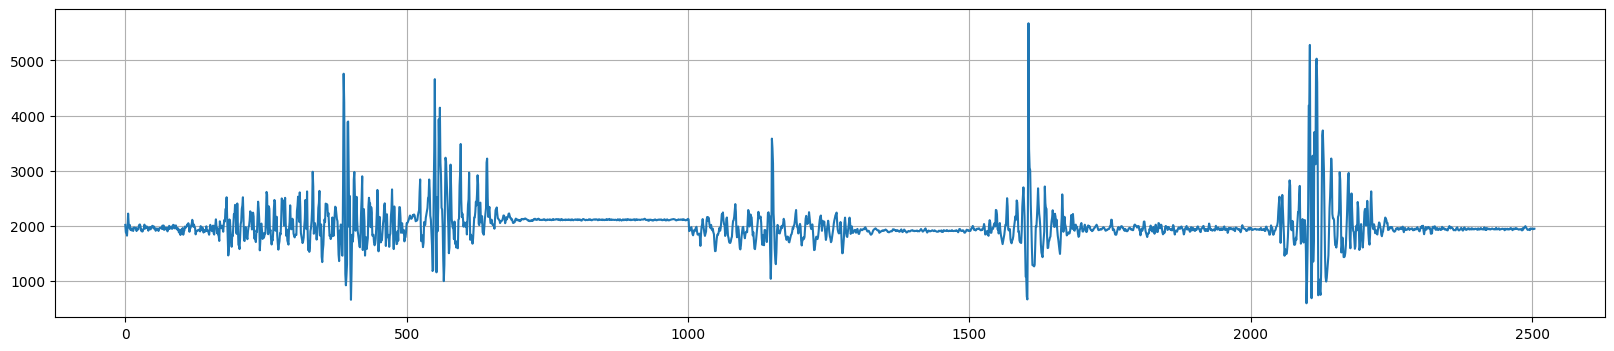

In [27]:
plt.figure(figsize=(20, 4))
dataframe_grafico = dataframe[dataframe['idTipoMovimento'].isin([f'{ID_MOB}'])]
dataframe_grafico = dataframe_grafico.reset_index(drop=True)
plt.grid(True)
plt.plot(dataframe_grafico.index, dataframe_grafico['MAGNITUDE_ACEL'])
# plt.savefig(f'C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\mobilidade\\mobilidade_{ID_MOB}.png', dpi=300, bbox_inches='tight')

### Análise gráfica da mobilidade dos usuários

In [6]:
# dataframe_grafico = dataframe[dataframe['idTipoMovimento'].isin([f'{ID_MOB}'])]
# for usuario in dataframe_grafico['idUsuario'].unique():
#     dados_usuario = dataframe_grafico[dataframe_grafico['idUsuario'] == usuario]  # Filtrar dados para o usuário atual
#     plt.plot(dados_usuario['tempo'], dados_usuario['MAGNITUDE_ACEL'], label=f'Usuário {usuario}')
#     plt.title('Magnitude da Aceleração por Usuário')
#     plt.xlabel('Tempo')
#     plt.ylabel('Magnitude da Aceleração')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f'C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\mobilidade\\mobilidade_{ID_MOB}_{usuario}.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()

### Usuário a ser treinado e analisado

In [7]:
# ID_USU = 'U01' # Alterar usuário a cada novo treinamento

### Visualiza dataset

In [28]:
# dataframe_teste = dataframe_grafico[dataframe_grafico['idUsuario'].isin([f'{ID_USU}'])]
dataframe_teste = dataframe_grafico.drop(columns='idUsuario')
dataframe_teste = dataframe_teste.drop(columns='idTipoMovimento')
dataframe_teste


,acelX,acelY,acelZ,girX,girY,girZ,MAGNITUDE_ACEL,MAGNITUDE_GIR
0,-668.0,-1904.0,24.0,5416.0,-677.0,-3814.0,2017.923685,6658.677121
1,-498.0,-1800.0,221.0,1574.0,1041.0,-4206.0,1880.650154,4609.945011
2,-468.0,-1798.0,309.0,11153.0,-10325.0,-11530.0,1883.430116,19077.104969
3,-643.0,-1706.0,10.0,31605.0,-11758.0,-22507.0,1823.179914,40542.467093
4,6.0,-1966.0,200.0,16301.0,-6441.0,-6021.0,1976.155864,18532.714939
...,...,...,...,...,...,...,...,...
2500,-748.0,-1795.0,71.0,5798.0,-795.0,-826.0,1945.911098,5910.254225
2501,-763.0,-1790.0,68.0,5767.0,-85.0,-1302.0,1947.021572,5912.758916
2502,-738.0,-1793.0,66.0,5307.0,-2320.0,-1326.0,1940.064174,5941.794763
2503,-780.0,-1786.0,85.0,5835.0,-153.0,-921.0,1950.748831,5909.219492


## Pré-processamento de Dados

### Cálculo de métricas em janelas deslizantes

In [29]:
intervalo_amostras = 10  # número de amostras por segmento (400ms)

# Inicializar listas para armazenar os resultados
medias_mag = []
maximas_mag = []
minimas_mag = []
dados_segmentos = []

# Analisar segmentos com janela deslizante
for i in range(len(dataframe_teste) - intervalo_amostras + 1):
    segmento = dataframe_teste.iloc[i:i + intervalo_amostras]

    # Aceleração
    media_x = segmento['acelX'].mean()
    media_y = segmento['acelY'].mean()
    media_z = segmento['acelZ'].mean()
    media_mag = segmento['MAGNITUDE_ACEL'].mean()
    
    max_x = segmento['acelX'].max()
    max_y = segmento['acelY'].max()
    max_z = segmento['acelZ'].max()
    max_mag = segmento['MAGNITUDE_ACEL'].max()
    
    min_x = segmento['acelX'].min()
    min_y = segmento['acelY'].min()
    min_z = segmento['acelZ'].min()
    min_mag = segmento['MAGNITUDE_ACEL'].min()

    std_x = segmento['acelX'].std()
    std_y = segmento['acelY'].std()
    std_z = segmento['acelZ'].std()
    std_mag = segmento['MAGNITUDE_ACEL'].std()

    # Giroscópio
    media_gir_x = segmento['girX'].mean()
    media_gir_y = segmento['girY'].mean()
    media_gir_z = segmento['girZ'].mean()
    media_gir = segmento['MAGNITUDE_GIR'].mean()
    
    max_gir_x = segmento['girX'].max()
    max_gir_y = segmento['girY'].max()
    max_gir_z = segmento['girZ'].max()
    max_mag_gir = segmento['MAGNITUDE_GIR'].max()
    
    min_gir_x = segmento['girX'].min()
    min_gir_y = segmento['girY'].min()
    min_gir_z = segmento['girZ'].min()
    min_mag_gir = segmento['MAGNITUDE_GIR'].min()

    std_gir_x = segmento['girX'].std()
    std_gir_y = segmento['girY'].std()
    std_gir_z = segmento['girZ'].std()
    std_mag_gir = segmento['MAGNITUDE_GIR'].std()

    # Adicionando as métricas à lista
    medias_mag.append(media_mag)
    maximas_mag.append(max_mag)
    minimas_mag.append(min_mag)

    # Adicionando os dados do segmento à lista de dados
    dados_segmentos.append({
        'seg': i + 1,
        'med_x': media_x,
        'med_y': media_y,
        'med_z': media_z,
        'med_mag': media_mag,
        'max_x': max_x,
        'max_y': max_y,
        'max_z': max_z,
        'max_mag': max_mag,
        'min_x': min_x,
        'min_y': min_y,
        'min_z': min_z,
        'min_mag': min_mag,
        'std_x': std_x,
        'std_y': std_y,
        'std_z': std_z,
        'std_mag': std_mag,
        'med_gir_x': media_gir_x,
        'med_gir_y': media_gir_y,
        'med_gir_z': media_gir_z,
        'med_gir': media_gir,
        'max_gir_x': max_gir_x,
        'max_gir_y': max_gir_y,
        'max_gir_z': max_gir_z,
        'max_gir': max_mag_gir,
        'min_gir_x': min_gir_x,
        'min_gir_y': min_gir_y,
        'min_gir_z': min_gir_z,
        'min_gir': min_mag_gir,
        'std_gir_x': std_gir_x,
        'std_gir_y': std_gir_y,
        'std_gir_z': std_gir_z,
        'std_gir': std_mag_gir
    })

dataframe_segmentado = pd.DataFrame(dados_segmentos)
dataframe_segmentado = dataframe_segmentado.fillna(0)
dataframe_segmentado


,seg,med_x,med_y,med_z,med_mag,max_x,max_y,max_z,max_mag,min_x,...,max_gir_z,max_gir,min_gir_x,min_gir_y,min_gir_z,min_gir,std_gir_x,std_gir_y,std_gir_z,std_gir
0,1,-403.6,-1911.0,177.9,1975.914508,6.0,-1706.0,311.0,2222.692286,-668.0,...,4376.0,40542.467093,-2530.0,-11758.0,-22507.0,1645.751804,10272.041304,8063.130672,8011.808108,11913.263935
1,2,-365.8,-1913.1,185.6,1969.056128,6.0,-1706.0,311.0,2222.692286,-643.0,...,4376.0,40542.467093,-2530.0,-11758.0,-22507.0,1645.751804,10357.713444,8104.287472,8100.667921,12138.821020
2,3,-352.8,-1921.3,167.1,1972.789027,6.0,-1706.0,311.0,2222.692286,-643.0,...,4376.0,40542.467093,-2530.0,-11758.0,-22507.0,1645.751804,10194.318647,8090.220063,8119.775610,11980.504336
3,4,-347.2,-1932.2,144.5,1979.722282,6.0,-1706.0,311.0,2222.692286,-643.0,...,4376.0,40542.467093,-2530.0,-11758.0,-22507.0,1645.751804,10112.260290,7402.458451,7667.307756,11833.950022
4,5,-327.5,-1950.5,157.2,1991.980908,6.0,-1882.0,311.0,2222.692286,-586.0,...,4376.0,18532.714939,-2530.0,-6441.0,-6021.0,1645.751804,5161.227891,6267.880914,2729.796454,5666.546858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2492,-735.5,-1792.6,81.7,1939.419456,-719.0,-1777.0,93.0,1953.537304,-768.0,...,2604.0,6242.830528,5078.0,-2906.0,-941.0,5312.968097,298.193543,730.038934,1277.459549,293.314802
2492,2493,-738.7,-1792.4,79.6,1940.380911,-719.0,-1777.0,93.0,1953.537304,-768.0,...,2073.0,6138.887684,5078.0,-2906.0,-1302.0,5312.968097,318.699719,894.921995,1098.603705,261.329841
2493,2494,-740.1,-1793.3,77.3,1941.650383,-719.0,-1777.0,93.0,1953.537304,-768.0,...,1308.0,6138.887684,5078.0,-2906.0,-1326.0,5312.968097,320.676732,917.725909,877.974032,248.557912
2494,2495,-746.2,-1792.9,76.5,1943.600695,-723.0,-1777.0,92.0,1953.537304,-780.0,...,732.0,6138.887684,5170.0,-2906.0,-1326.0,5312.968097,318.294134,996.900870,659.265425,246.936082


## Processo de clusterização

In [41]:
a = dataframe_segmentado['min_x']
b = dataframe_segmentado['max_x']

c = dataframe_segmentado['min_y']
d = dataframe_segmentado['max_y']

e = dataframe_segmentado['min_z']
f = dataframe_segmentado['max_z']

g = dataframe_segmentado['med_mag']
h = dataframe_segmentado['std_mag']

dados_segmentos = list(zip(a,b,c,d,e,f,g,h))
array_bidimensional = np.array(dados_segmentos)


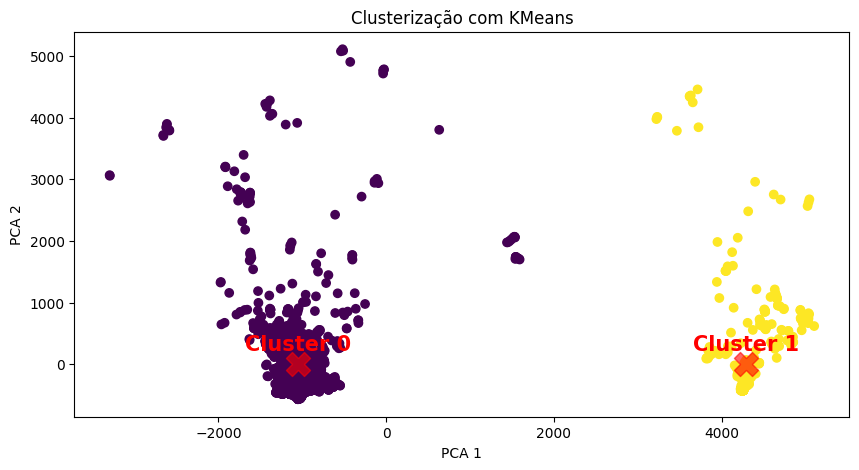

In [42]:
# Aplicando o KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(array_bidimensional)
labels = kmeans.labels_

# PCA para reduzir para 2 componentes e visualização
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(array_bidimensional)

# Plotando os clusters
plt.figure(figsize=(10, 5))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')

# Centroides dos clusters
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, alpha=0.6, marker='X')

# Anotação dos clusters
for i, (x, y) in enumerate(centroids):
    plt.annotate(f'Cluster {i}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=15, fontweight='bold', color='red')

plt.title('Clusterização com KMeans')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.savefig(f'C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\cluster\\svm_matriz_treinamento_{ID_MOB}.png', dpi=300, bbox_inches='tight')
plt.show()

## Seleção de features

In [12]:
# dicionario_de_label = {0:'Andando', 1:'Tropeçou'}
dataframe_segmentado['cluster'] = labels
# dataframe_segmentado['cluster'] = dataframe_segmentado['cluster'].map(dicionario_de_label)
dataframe_segmentado = dataframe_segmentado[['min_x','max_x','min_y','max_y','min_z','max_z','med_mag','std_mag','cluster']] 
dataframe_segmentado.to_excel("dataframe_segmentado.xlsx")
dataframe_segmentado
# dataframe_grafico.shape

,min_x,max_x,min_y,max_y,min_z,max_z,med_mag,std_mag,cluster
0,-668.0,6.0,-2138.0,-1706.0,10.0,311.0,1975.914508,111.399965,0
1,-643.0,6.0,-2138.0,-1706.0,10.0,311.0,1969.056128,110.634853,0
2,-643.0,6.0,-2138.0,-1706.0,10.0,311.0,1972.789027,107.916909,0
3,-643.0,6.0,-2138.0,-1706.0,10.0,311.0,1979.722282,103.682139,0
4,-586.0,6.0,-2138.0,-1882.0,36.0,311.0,1991.980908,89.377252,0
...,...,...,...,...,...,...,...,...,...
2491,-768.0,-719.0,-1804.0,-1777.0,60.0,93.0,1939.419456,10.304906,0
2492,-768.0,-719.0,-1804.0,-1777.0,60.0,93.0,1940.380911,10.542075,0
2493,-768.0,-719.0,-1804.0,-1777.0,60.0,93.0,1941.650383,9.515512,0
2494,-780.0,-723.0,-1804.0,-1777.0,60.0,92.0,1943.600695,9.137178,0


## Treinamento do Modelo

[[389   0]
 [  0 111]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       389
           1       1.00      1.00      1.00       111

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



Text(0.5, 1.0, 'Matriz de Confusão D07')

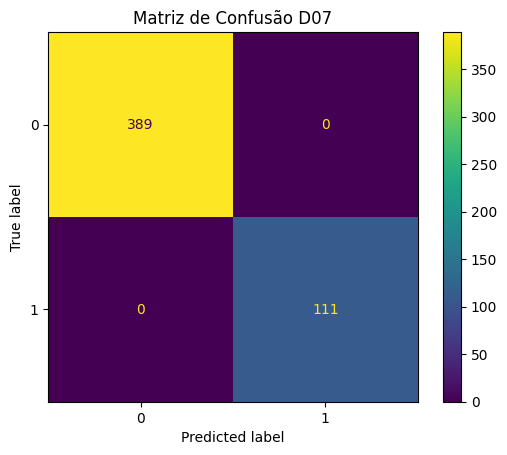

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataframe_segmentado[['min_x','max_x','min_y','max_y','min_z','max_z','med_mag','std_mag']], dataframe_segmentado['cluster'], train_size=0.8, random_state=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear')  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Matriz de Confusão {ID_MOB}')
# plt.savefig(f'C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\matriz_de_confusao\\svm_matriz_treinamento_{ID_MOB}_{ID_USU}.png', dpi=300, bbox_inches='tight')



## Salva Modelo

In [14]:
# if ID_USU == 'U01':
#     with open('modelos/svm_model_d07.joblib', 'wb') as file:
#         dump(model, file)
# else:
#     with open('modelos/svm_model_d07.joblib', 'ab') as file:
#         dump(model, file)